In [35]:
# -*- coding: latin-1 -*-

#!/usr/bin/env python
from scipy import arange
from numpy import *
import time
import os
from matplotlib.pyplot import *
from scipy.integrate import *

from modelEquations import *
from MFBfunctions import *
from parameters import *

### Set up the model parameters

In [36]:
### Command line arguments
cmdArg = {
    'tcp'  : 50e-3,
    'tf'   : 100e-3,
    'tstep': 1e-3,
    'save' : 1,
}

simName = 'trial/'
### Simulation time
ti, tf = 0.0, cmdArg['tf']
tstep = cmdArg['tstep']
tcp = cmdArg['tcp']

### Geometrical arrangement of all the compartments
### a:n   = a, a+1, a+2,...,n-1
### a:n:i = a, a+i, a+2*i,..., until (n-1)
modelInput = '''[0:2:2, 0:20:4, 0:2:3]
                [38:40:2, 0:20:4, 0:2:3]
                [0:40:5, 0:20:5, 7:10:3]
                [0:40:4, 0:20:5, 5:7:2]
                [0:40:2, 0:20:4, 3:5:2]
                [2:38:2, 0:20:2, 2:3]
                [2:38, 0:20, 0:2]
                '''

modelInput = "[0:1,0:1,0:1]"
#modelInput = "[0:2,0:1,0:1]"

### MFB bounding box
#bb = [40, 20, 10]
bb = [1]*3 #+ [1]*2
boundingBox = "[0:" + str(bb[0]) + ",0:" + str(bb[1]) + ",0:" + str(bb[2]) + "]"

### Get all the compartments as
### {'i-j-k': [i,j,k,lenth,width,height]}
cmpts = compartments(modelInput)
#for k in sorted(cmpts.iterkeys()): print "%s: %s" % (k, cmpts[k])

### List of model objects for each compartment
cModels = []
for cname, cdim in [[k, cmpts[k]] for k in sorted(cmpts.iterkeys())]: # sorted by name
    cModels.append(mfb({'Ca':[10e-7], 'PMCA': []},# 'PMCA': [], 'calbindin': []},
                  name = cname,
                  dim = cdim,
                  nbrs = getNeighbours({cname: cdim}, cmpts))
                 )
'''
c0 = '0-0-0'
cModels[0] = mfb({'Ca':[], 'PMCA': [], 'calbindin': []},
                 name = c0,
                 dim = cmpts[c0],
                 nbrs = getNeighbours({c0: cmpts[c0]}, cmpts))
'''

### Make a list of initial index of each compartment
cmpi = initialIndex(cModels)

In [37]:
### print model details
for cm in cModels:
    print cm.name, cm.dim, cm.nbrs, cmpi[cm.name]
    for n in cm.nbrs:
        print cmpi[n]

0-0-0 [0, 0, 0, 1, 1, 1] [] 0


Go ahead! All good with the geometry


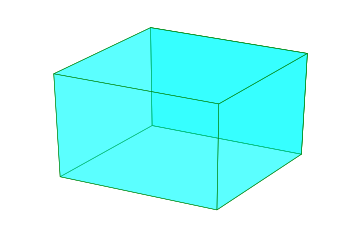

Number of compartments: 1


In [38]:
### Check if no compartments have overlapping volumes
### and there are no gaps in the geometry
if checkGeometry(boundingBox, cmpts):
    print 'Go ahead! All good with the geometry'
    plotCompartments(cmpts, bb)
    print 'Number of compartments:', len(cmpts)

In [39]:
tt=0.0
flux = 1e4
### Putting all compartments together
def dXdt(t, X):
    global tt
    if t>tt:
        print 't =', tt
        tt += tcp/10


    dX = []
    j=0
    for cm in cModels:
        # All compartments have V value of (0,0,0)th compartment
        #cm.V = cModels[0].V

        ## Collect dX values from each compartment
        dX += cm.dXdt(X[j:j+cm.nVar], t)

        # Calcium Flux
        caFlux = 0
        for nbr in cm.nbrs:
            caFlux += flux*(X[cmpi[nbr]] - X[j]) #ADΔ(Ca)/Δx
        dX[j] += caFlux

        j += cm.nVar # increment counter to 1st element of next compartment

    return dX


In [40]:
### initial values
X0 = []
for cm in cModels:
    X0 += cm.X0
#print 'X0:', X0,
print 'Total number of equations:', len(X0)

### Solve ODE
timei = time.time()
print "solving the ODE..."

tinterval = []
aa = arange(ti, tf, tcp)
for i in range(len(aa[:-1])):
    tinterval += [[aa[i], aa[i+1]]]
tinterval += [[aa[-1], tf]]

#set_printoptions(precision=4)
temp =  1
for ti, tf in tinterval:
    t_eval = linspace(ti, tf, round((tf - ti)/tstep) + 1)[:-1]

    sol = solve_ivp(dXdt, [ti, tf], X0, t_eval=t_eval, rtol=1e-3, atol=1e-6)

    ### Last values of sol as X0
    X0 = sol.y.T[-1]

    ### Adding sol to solution till previous checkpoint
    if temp:
        t = sol.t
        y = sol.y
        temp = 0
    else:
        t = concatenate((t, sol.t))
        y = concatenate((y, sol.y), axis=1)

    ### Saving data till current checkpoint in files
    if cmdArg['save']:
        tsavei = time.time()
        for cm in cModels:
            header = 't\t\t'
            vname = sorted(result.data[cm.name].iteritems(), key=lambda (k,v): (v,k))
            for vn in vname:
                header += vn[0] + '\t\t'

            v = concatenate(([t], y[cmpi[cm.name]:cmpi[cm.name]+cm.nVar])).T

            dir = 'data/'+simName
            if not os.path.exists(dir):
                os.makedirs(dir)
            savetxt(dir+cm.name+'.txt', v, header=header, fmt='%.4e', delimiter='\t')

        tsavef = time.time()
        print 'Time taken for saving:', tsavef - tsavei

timef = time.time()
print '\nDONE! | Time elapsed: ', timef-timei

Total number of equations: 4
solving the ODE...
[0.   0.05] 0.0
[[0.0, 0.05], [0.05, 0.1]]
t = 0.0
t = 0.005
t = 0.01
t = 0.015


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


t = 0.02
t = 0.025
t = 0.03
t = 0.035
t = 0.04
t = 0.045
t = 0.05
Time taken for saving: 0.00126600265503
t = 0.055
t = 0.06
t = 0.065
t = 0.07
t = 0.075
t = 0.08
t = 0.085
t = 0.09
t = 0.095
Time taken for saving: 0.00151085853577

DONE! | Time elapsed:  1.02245402336


In [41]:
### Organise data in result.data dictionary
for cname, idx in cmpi.items():
    for vname, v in result.data[cname].items():
        result.data[cname][vname] = y[idx+v]

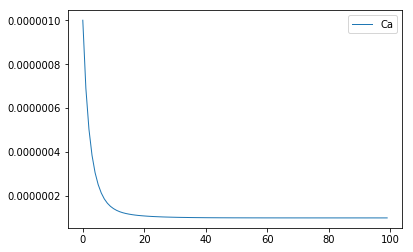

In [42]:
### Plot some results
fig, ax = subplots()
for cname, c in result.data.items():
    for vname, v in result.data[cname].items():
        if vname == 'Ca':
            figY = plot(t*1e3, v, lw=1, label=vname)

legend()
show()